In [2]:
import sympy as sp
from sympy import *
import numpy as np
from opt_einsum import contract as _contract
import itertools as itt
from IPython.display import display, Latex
sp.init_printing()

def contract(expr,*tensors,**args):
    if contract.dest is not None:
        expr+='->'+contract.dest
    rtval= _contract(expr,*tensors, backend='object',**args)
    return rtval.item() if rtval.shape==() else Array(rtval)
    
class contract_dest:
    def __init__(self, dest):
        self.dest= dest
    def __enter__(self):
        contract.dest,self.dest= self.dest,contract.dest
    def __exit__(self, *args):
        contract.dest= self.dest
contract.dest=None

def simplify(expr):
    expr= sp.simplify(expr, ratio=1.7)
    expr=trigsimp(expr, method='fu')
    return expr

def print_nonzero_terms(v):
    for i in itt.product(*[range(d) for d in v.shape]):
        if v[i]!=0:
            print(i,v[i])

def covariant_derivative(v,indice_positions=''):
    global coords,Gm
    # a: tensor, indices: list of {'u' 'd' 'i'}, stands for upper, lower, internal
    rtval=derive_by_array(v,coords)
    for i,ind in enumerate(indice_positions):
        if ind=='u':
            # D_m v^a=∂_m v^a+Γ^a_mb v^b
            rtval+=np.swapaxes(contract('amb,b...->ma...',Gm,np.swapaxes(v,0,i)),1,i+1)
        elif ind=='d':
            # D_m v_a=∂_m v_a-Γ^b_ma v^b
            rtval-=np.swapaxes(contract('bma,b...->ma...',Gm,np.swapaxes(v,0,i)),1,i+1)
    return Array(rtval)
D=covariant_derivative

In [4]:

AdSRad=symbols('L')
cosmos_const=-3/AdSRad**2  # dim=4 3=(4-1)(4-2)/2

t,eta,x,y=coords=symbols('t,eta,x,y')
# t->-t fixed nondiag g_t*=0
# if we also want x->-x y->-y although translational inv at x is broken, we have all nondiag elements vanishes.
ft=Function('ft')(eta,x,y)
fx=Function('fx')(eta,x,y)
fy=Function('fy')(eta,x,y)
fnx=Function('fnx')(eta,x,y)
fny=Function('fny')(eta,x,y)
fxy=Function('fxy')(eta,x,y)

g=diag(-exp(ft),1,exp(fx),exp(fy))
# g[1,2]=g[2,1]=fnx
# g[1,3]=g[3,1]=fny
# g[2,3]=g[3,2]=fxy

display(g)

⎡  ft(η, x, y)                               ⎤
⎢-ℯ             0       0             0      ⎥
⎢                                            ⎥
⎢      0        1       0             0      ⎥
⎢                                            ⎥
⎢                   fx(η, x, y)              ⎥
⎢      0        0  ℯ                  0      ⎥
⎢                                            ⎥
⎢                                 fy(η, x, y)⎥
⎣      0        0       0        ℯ           ⎦

In [5]:


# spacial dim, g^mn, ∂_i g^mn
ginv=g.inv()
ginv=simplify(ginv)


# Γ^k_ij=1/2 g^kl (∂_i g_jl+∂_j g_il-∂_l g_ij)
dg=derive_by_array(g,coords)
with contract_dest('kij'):
    Gm=(contract('kl,ijl',ginv,dg)+contract('kl,jil',ginv,dg)-contract('kl,lij',ginv,dg))/2
Gm=simplify(Gm)
# display(Gm)


# R^r_smn=∂m Γ^r_ns - ∂n Γ^r_ms +Γ^r_ml Γ^l_ns - Γ^r_nl Γ^l_ms
dGm=derive_by_array(Gm,coords)
with contract_dest('rsmn'):
    Rie=contract('mrns',dGm)-contract('nrms',dGm)+contract('rml,lns',Gm,Gm)-contract('rnl,lms',Gm,Gm)
Rie=simplify(Rie)

# R_ij=R^r_irj
with contract_dest('ij'):
    Ric=contract('rirj',Rie)
Ric=simplify(Ric)

RicS=contract('ij,ij',Ric,ginv)
RicS=simplify(RicS)

# E_ij=R_ij-1/2 R g_ij+Λ g_ij
eqT=Ric+Array(g)*(cosmos_const-RicS/2)
eqT=simplify(eqT)

eqT




⎡                                                                                                                     
⎢                                                                                                         2    ft(η, x
⎢ ft(η, x, y) - fx(η, x, y) ∂               ∂                  ft(η, x, y) - fx(η, x, y) ⎛∂              ⎞    ℯ       
⎢ℯ                         ⋅──(fx(η, x, y))⋅──(fy(η, x, y))   ℯ                         ⋅⎜──(fy(η, x, y))⎟            
⎢                           ∂x              ∂x                                           ⎝∂x             ⎠            
⎢────────────────────────────────────────────────────────── - ───────────────────────────────────────────── - ────────
⎢                            4                                                      4                                 
⎢                                                                                                                     
⎢                                               

In [12]:
phi=Function('phi')(eta,x,y)
pi=Function('pi')(eta,x,y)

m=symbols('m')
VFunc=Function('V')
sqrtg=sqrt(-g.det())

dphi=D(phi)

L=-contract('i,j,ij',dphi,dphi,ginv)/2-m**2*phi**2/2-VFunc(phi)
L=simplify(L)
L

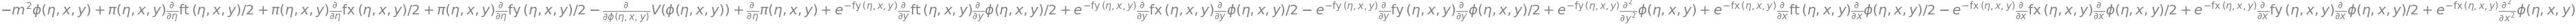

In [14]:
dLddphi=Array([0,diff(L,diff(phi,eta)),0,0])
dphi=D(phi)
dLddphi=Array([diff(L,x) if x!=0 else 0 for x in dphi])



eom=diff(L,phi)-contract('ii',D(dLddphi,'u'))
eom=eom.subs(diff(phi,eta),pi)
eom=expand(simplify(eom))
eom